In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os

In [3]:
# TODO: Iterate over the whole file
# Options:
# Do it with pyarrow slice by slice
parquet_file = "all_yellow_tripdata.parquet"
parquet_reader = pq.ParquetFile(parquet_file)
num_rows = parquet_reader.metadata.num_rows
num_row_groups = parquet_reader.num_row_groups


In [9]:
# Remove unwanted columns
table = pq.read_table(parquet_file)
filtered_table = table.drop(['VendorID', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'])
pq.write_table(filtered_table, "all_yellow_tripdata_filtered.parquet")

In [10]:
parquet_file = "all_yellow_tripdata_filtered.parquet"
parquet_reader = pq.ParquetFile(parquet_file)

In [11]:
table = pq.read_table(parquet_file)
df = table.to_pandas()


In [12]:
df.shape[0]

118425410

In [13]:
print("Number of rows:", num_rows)
print("Number of cols:", df.shape[1])
print("Data types:") 
print(df.dtypes)

Number of rows: 118425410
Number of cols: 5
Data types:
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
PULocationID                      int64
DOLocationID                      int64
dtype: object


In [14]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,142,43
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,238,151
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,132,165
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,138,132
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,68,33


To save space, drop unneeded columns before analysis

In [8]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [6]:
# As the dataset is too large to convert to a pandas df in one go we will iterate over each row group of the dataset and collect the necessary data
categorical_columns = df.select_dtypes(['object']).columns.values.tolist()

categorical_columns += ['PULocationID', 'DOLocationID', 'payment_type']
for column in categorical_columns:
    df[column] = df[column].astype('category')

numeric_columns = df.select_dtypes(['int64', 'float64', 'datetime64']).columns
# Cardinalitites
df_numeric_cards = {}
df_mins = {}
df_maxs = {}
df_stds = {}
df_means = {}
for column in numeric_columns:
    df_numeric_cards[column] = set()
    df_mins[column] = None
    df_maxs[column] = None
    df_means[column] = []
    df_stds[column] = []

df_categorical_cards = {}
df_freqs = {}
for column in categorical_columns:
    df_categorical_cards[column] = set()
    df_freqs[column] = {}

df_counts = {}
df_missing = {}
for column in df.columns:
    df_counts[column] = []
    df_missing[column] = 0

df_negative_passengers = 0
df_dropoff_before_pickup = 0
df_fare_less_than_total = 0

array([[<Axes: title={'center': 'VendorID'}>,
        <Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'fare_amount'}>,
        <Axes: title={'center': 'extra'}>],
       [<Axes: title={'center': 'mta_tax'}>,
        <Axes: title={'center': 'tip_amount'}>,
        <Axes: title={'center': 'tolls_amount'}>,
        <Axes: title={'center': 'improvement_surcharge'}>],
       [<Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'congestion_surcharge'}>,
        <Axes: title={'center': 'airport_fee'}>, <Axes: >]], dtype=object)

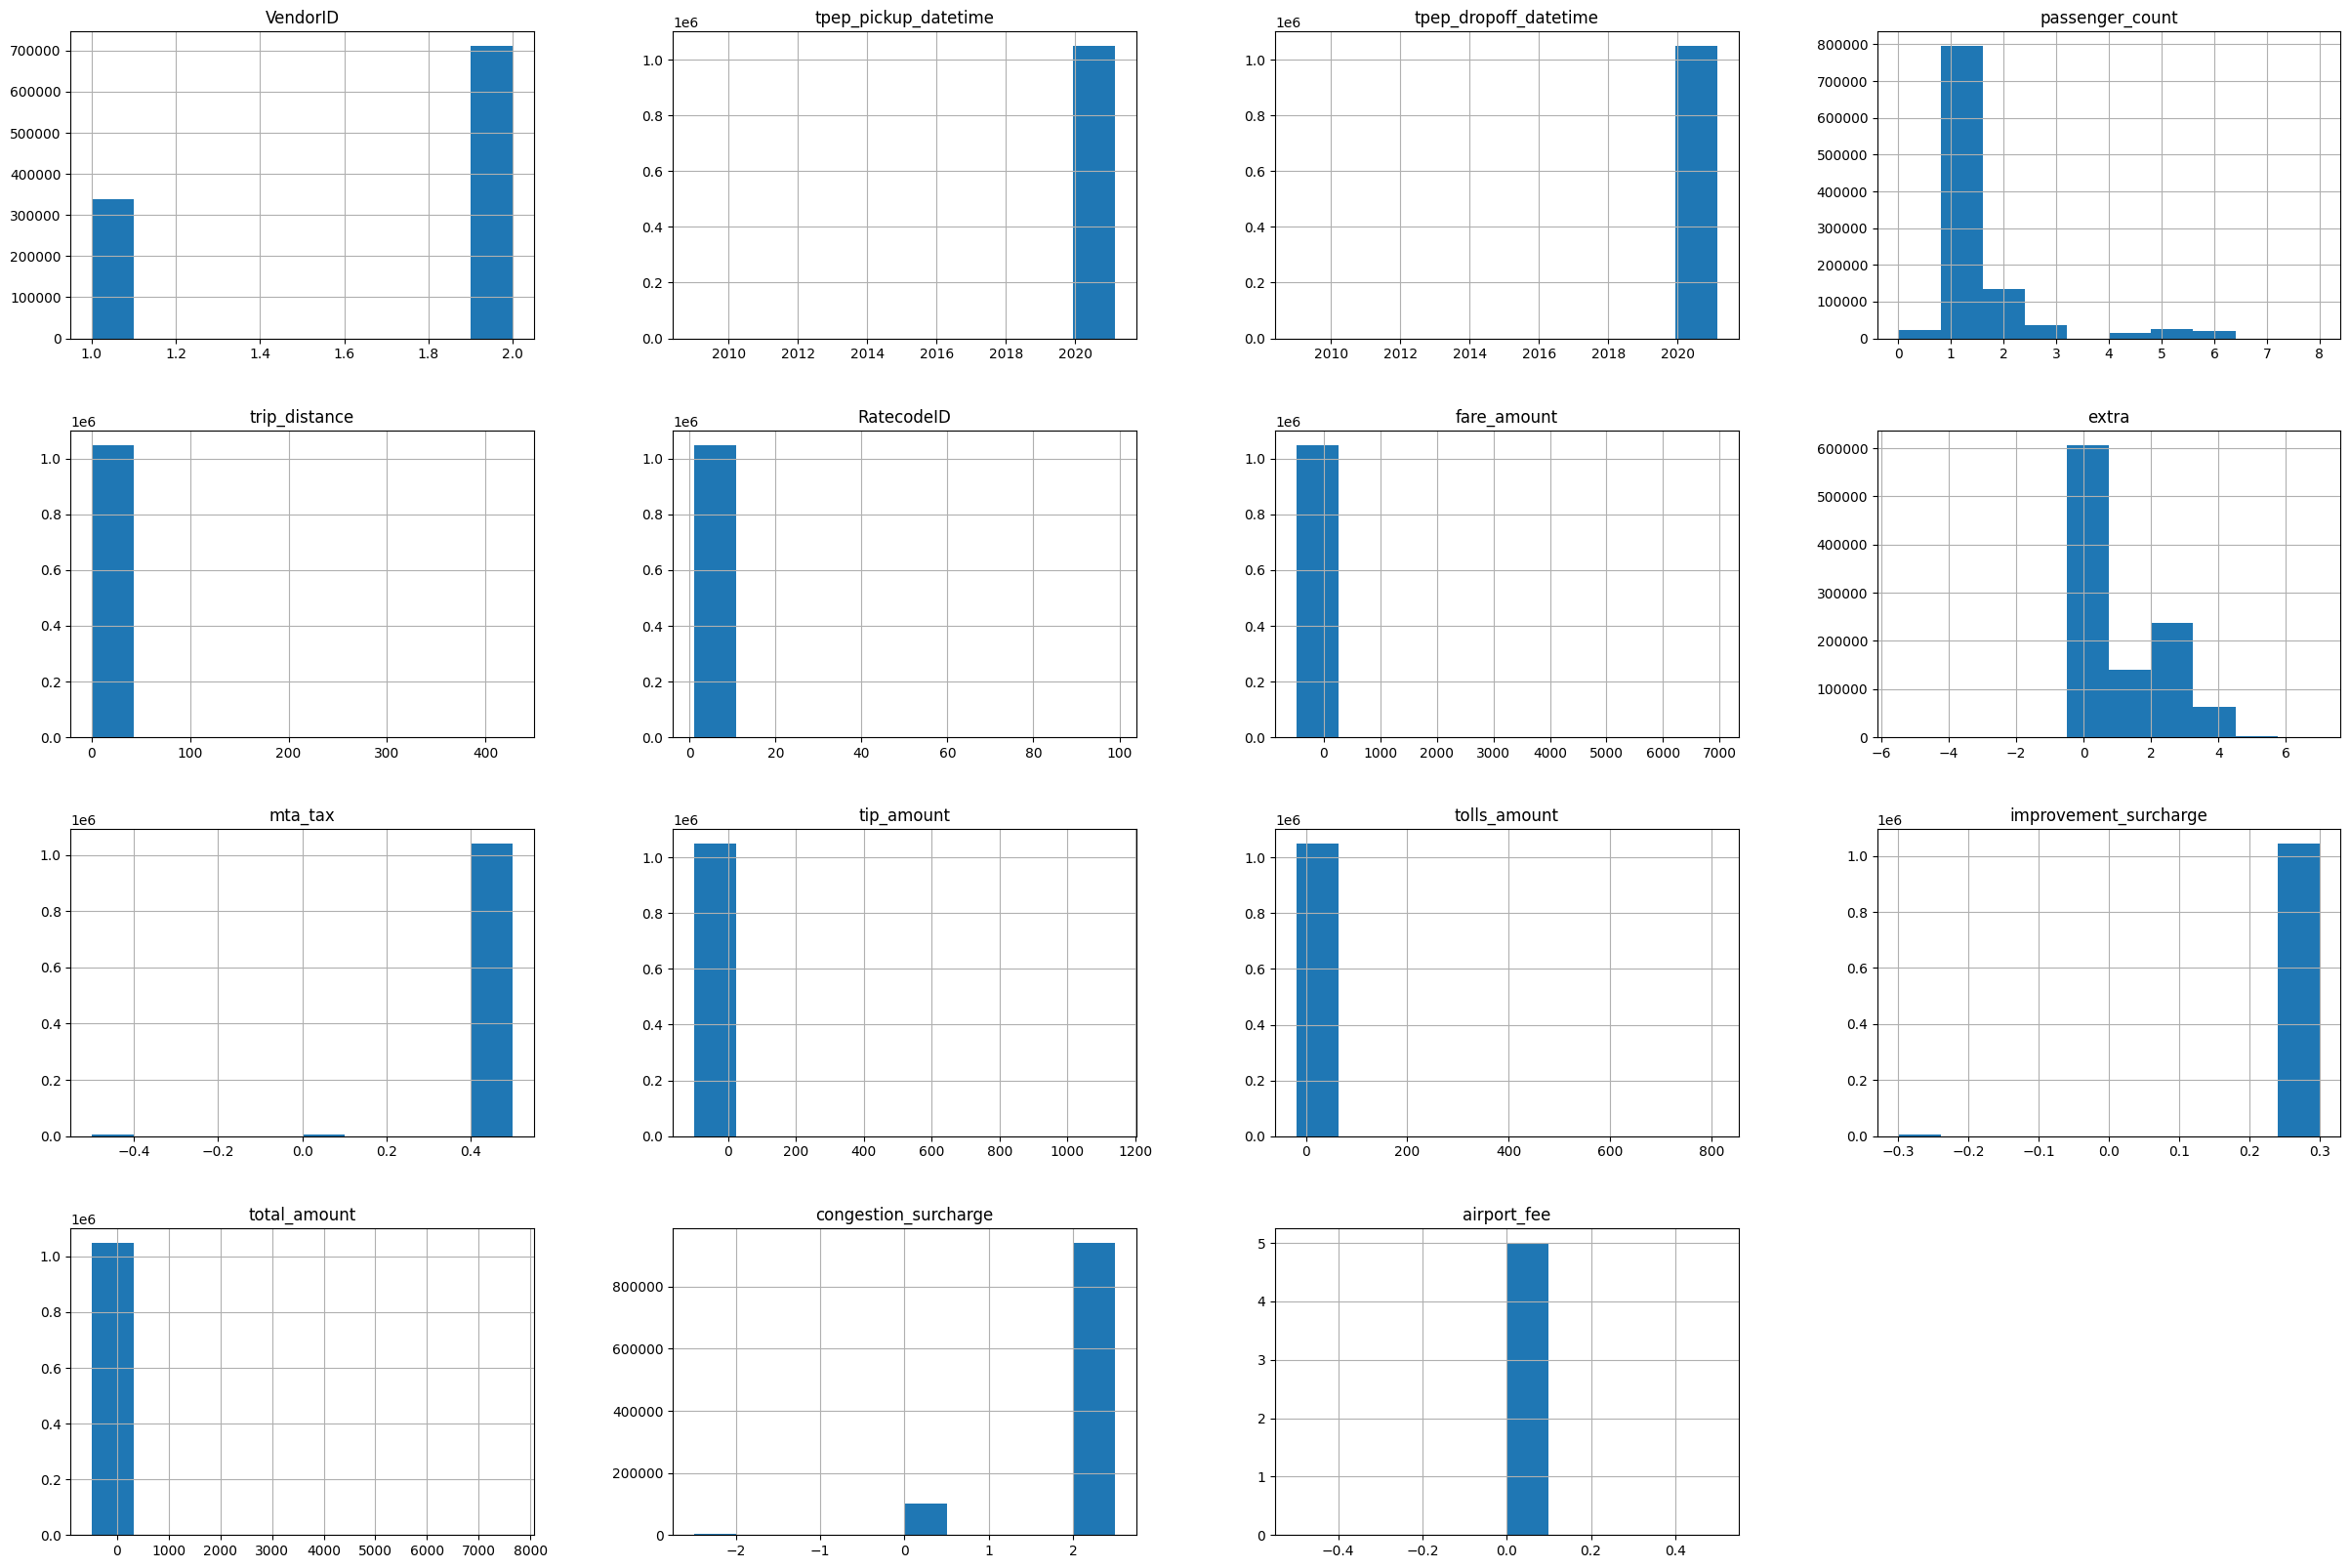

In [7]:
df.hist(figsize=(30, 20))

### Logical integrity tests
1. dropoff not before pickup
2. Passenger count not negative
3. Pickup date before 2021
4. fare amount not greater than total amount